<a href="https://colab.research.google.com/github/Youssef-Chip/lab1/blob/main/lab2/01_data_and_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
SEED = 42

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)


In [6]:
DATA_DIR = "/Users/mr.youssef/Dropbox/lab1/lab2/dataset/UCI_HAR_Dataset"

In [7]:
ACTIVITY_NAMES = ['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


In [8]:
def load_inertial_signals(subset):
    signals = ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z','total_acc_x', 'total_acc_y', 'total_acc_z']
    loaded_signals = []
    for sig in signals:
        path = os.path.join(DATA_DIR, subset, 'Inertial Signals', f'{sig}_{subset}.txt')
        loaded_signals.append(pd.read_csv(path, sep=r'\s+', header=None).values)
        # each file has shape: (N, 128) where N is the number of windows (2.56 seconds per window) and 128 is sequential time steps for that specific window
    # Go from 9 arrays of: (N, 128) to 1 matrix (N, 128, 9)
    return np.dstack(loaded_signals)

In [9]:
def load_y_and_subjects(subset):
    # y ==> 0 to 5 multiclass describing the activity
    # subjecs: each row has the ID of the specific human volunteer who was wearing the phone for that specific window
    y_path = os.path.join(DATA_DIR, subset, f'y_{subset}.txt')
    sub_path = os.path.join(DATA_DIR, subset, f'subject_{subset}.txt')
    y = pd.read_csv(y_path, sep=r'\s+', header=None).values.squeeze() - 1 # 0-indexed
    subjects = pd.read_csv(sub_path, sep=r'\s+', header=None).values.squeeze()
    return y, subjects

In [10]:
X_train = load_inertial_signals('train')
X_test = load_inertial_signals('test')
y_train, subjects_train = load_y_and_subjects('train')
y_test, subjects_test = load_y_and_subjects('test')

In [11]:
X_train.shape

(7352, 128, 9)

In [12]:
X_test.shape

(2947, 128, 9)

In [13]:
print(y_train.shape, subjects_train.shape)

(7352,) (7352,)


In [14]:
print(y_test.shape, subjects_test.shape)

(2947,) (2947,)


In [15]:
print(f"NaNs: {np.isnan(X_train).sum()} and Infs: {np.isinf(X_train).sum()}\n")

NaNs: 0 and Infs: 0



In [16]:
np.bincount(y_train)

array([1226, 1073,  986, 1286, 1374, 1407])

In [17]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [18]:
np.unique(subjects_train)


array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30])

In [19]:
# leakage check
unique_train_subs = np.unique(subjects_train)
# Hold out 4 subjects from the training pool for checking
val_subs = np.random.choice(unique_train_subs, size=4, replace=False)
# get everyone from the training pool instead the 4 subjects above
train_subs = np.setdiff1d(unique_train_subs, val_subs)
# Prove overlap is 0
train_val_overlap = set(train_subs).intersection(set(val_subs))
train_test_overlap = set(train_subs).intersection(set(subjects_test))

In [20]:
print(len(train_val_overlap), len(train_test_overlap))

0 0


In [21]:
class MajorityClassPredictor:
  """
  Trivial baseline model that always predicts the majority class.
  """
  def __init__(self):
    self.majorityClass = None

  def fit(self, trainLabels):
    """
    Method to find the most frequent class in the training labels
    """
    values, count = np.unique(trainLabels, return_counts=True)
    self.majorityClass = values[np.argmax(count)]

  def predict(self, numSamples):
    """
    Method to blindly return the majority class for every sample.
    """
    return np.full(numSamples, self.majorityClass)

In [ ]:
class BaselineMLP(nn.Module):
  """
  Baseline MLP model for classification tasks.
  - inputDim: number of input features
  - hiddenDim: Our hyperparameter for the hidden layer. This defines the size of
               the hidden layer.
  - numClasses: number of output classes
  """
  def __init__(self, inputDim, hiddenDim, numClasses):
    super(BaselineMLP, self).__init__()

    # Define the layers
    # Layer 1: Input -> Hidden
    self.layer1 = nn.Linear(inputDim, hiddenDim)
    self.activation = nn.ReLU()
    self.drop1 = nn.Dropout(0.3) # turn off 30% of neurons everytime data comes throuhg
    # Layer 2: Hidden -> Output
    self.layer2 = nn.Linear(hiddenDim, numClasses)

  def forward(self, X):
    """
    Method to perform forward propagation from:
    input layer -> hidden layer -> output layer.

    The 2D input X passes through the first layer, goes through ReLU activation,
    introducing non-linearity, and then passes through the second layer.
    """
    X = self.layer1(X)
    X = self.activation(X)
    X = self.drop1(X)
    X = self.layer2(X)
    return X

In [23]:
def create_dataloader(X, y, batch_size=64, shuffle=False):
    # Flatten: (N, 128, 9) -> (N, 128*9)
    X_flat = X.reshape(X.shape[0], -1)

    # Convert to PyTorch Tensors
    dataset = TensorDataset(
        torch.tensor(X_flat, dtype=torch.float32),
        torch.tensor(y, dtype=torch.long)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_mask = np.isin(subjects_train, train_subs)
val_mask = np.isin(subjects_train, val_subs)
X_t, y_t = X_train[train_mask], y_train[train_mask]
X_v, y_v = X_train[val_mask], y_train[val_mask]

train_loader = create_dataloader(X_t, y_t, shuffle=True)
val_loader = create_dataloader(X_v, y_v)
test_loader = create_dataloader(X_test, y_test)

In [24]:
dummy_model = MajorityClassPredictor()
dummy_model.fit(y_t)
print(f"Majority class found: {ACTIVITY_NAMES[dummy_model.majorityClass]} (Class {dummy_model.majorityClass})")

Majority class found: LAYING (Class 5)


In [25]:
num_test_samples = len(y_test)
dummy_preds = dummy_model.predict(num_test_samples)

In [26]:
dummy_acc = accuracy_score(y_test, dummy_preds)
dummy_macro_f1 = f1_score(y_test, dummy_preds, average='macro')

print(f"\nBaseline 0 Test Accuracy: {dummy_acc:.4f}")
print(f"Baseline 0 Test Macro-F1: {dummy_macro_f1:.4f}")


Baseline 0 Test Accuracy: 0.1822
Baseline 0 Test Macro-F1: 0.0514


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [37]:
def train_model(model, train_loader, val_loader, optimizer, epochs=15, clip_grad=False):
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for _ in range(epochs):
        model.train()
        epoch_train_loss = 0
        
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            optimizer.zero_grad() # Clear old gradients
            logits = model(X_b) # Forward pass
            loss = criterion(logits, y_b) # Calculate loss
            loss.backward() # Backpropagation
            
            # # Instability fix: Gradient Clipping
            # if clip_grad:
            #     nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step() # Update weights
            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for X_b, y_b in val_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                logits = model(X_b)
                loss = criterion(logits, y_b)
                epoch_val_loss += loss.item()
                
                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_b.cpu().numpy())
                
        history['train_loss'].append(epoch_train_loss / len(train_loader))
        history['val_loss'].append(epoch_val_loss / len(val_loader))
        history['val_acc'].append(accuracy_score(val_targets, val_preds))
    return history

In [38]:
INPUT_DIM = 128 * 9
HIDDEN_DIM = 256
NUM_CLASSES = 6

model_baseline = BaselineMLP(inputDim=INPUT_DIM, hiddenDim=HIDDEN_DIM, numClasses=NUM_CLASSES).to(device)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)
epochs = 20

In [40]:
baseline_report = train_model(model_baseline, train_loader, val_loader, optimizer_baseline, epochs)

In [41]:
def plot_curves(history, title="Training Curves"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='o', color='green')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [42]:
print("\nEvaluating on Test Set")
model_baseline.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model_baseline(X_batch)
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y_batch.numpy())

# Calculate final required metrics
final_acc = accuracy_score(test_targets, test_preds)
final_macro_f1 = f1_score(test_targets, test_preds, average='macro')

print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final Test Macro-F1: {final_macro_f1:.4f}")


Evaluating on Test Set
Final Test Accuracy: 0.9030
Final Test Macro-F1: 0.9031


In [29]:
print(classification_report(test_targets, test_preds, target_names=ACTIVITY_NAMES))



              precision    recall  f1-score   support

     WALKING       0.99      0.90      0.94       496
    UPSTAIRS       0.87      0.94      0.91       471
  DOWNSTAIRS       0.89      0.97      0.93       420
     SITTING       0.84      0.83      0.83       491
    STANDING       0.87      0.84      0.86       532
      LAYING       0.99      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



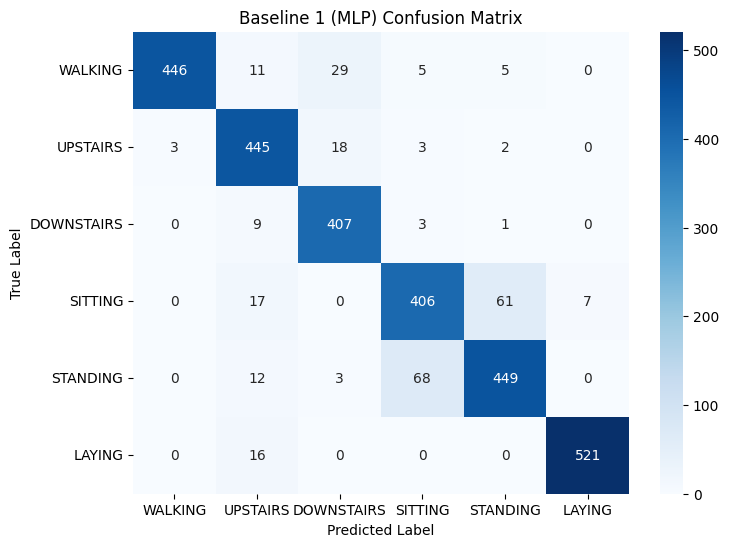

In [30]:
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ACTIVITY_NAMES, yticklabels=ACTIVITY_NAMES)
plt.title('Baseline 1 (MLP) Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

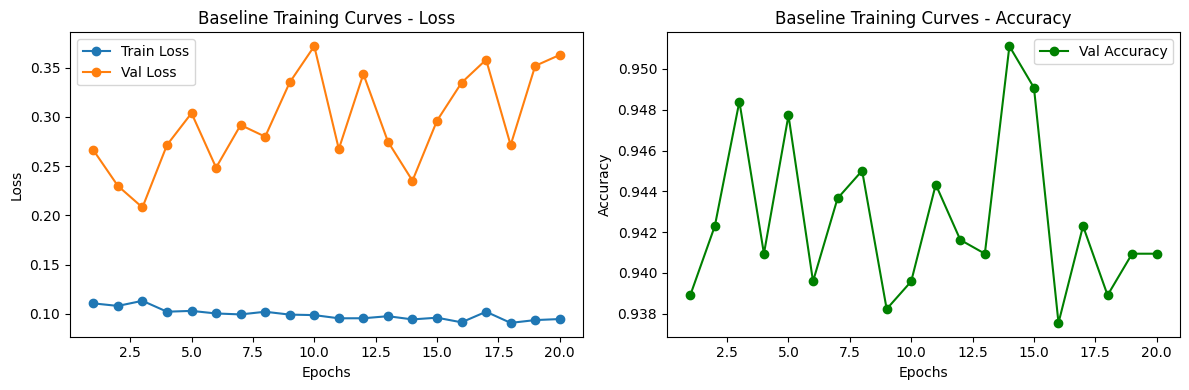

In [43]:
plot_curves(baseline_report, "Baseline Training Curves")